In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from skimage import exposure
from skimage.color.adapt_rgb import adapt_rgb, each_channel #, hsv_valu
from sklearn.model_selection import train_test_split
from skimage.filters import gaussian,laplace,sobel

from fastai import *
from fastai.vision import *

In [3]:
# To open 4 channel images 
# adapted from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb

import cv2

def open_4_channel(fname):
    fname = str(fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE # or we can use 0 for gray scale
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

0

In [4]:
# Modify the first layer of Conv net to take 4 channel input image

import torchvision

RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    

In [5]:
# Batch size
bs = 64

In [6]:
path = Path('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/')

In [7]:
path

PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification')

In [8]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [9]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [10]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [11]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [12]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [13]:
test_ids[:5]

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']

In [14]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [15]:
test_fnames[:5]

[PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [16]:
src.add_test(test_fnames, label='0');

In [17]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [18]:
#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])  # Sandeep's Version
protein_stats = ([0.16258, 0.13877, 0.10067, 0.16358], [0.21966, 0.18559, 0.25573,0.22066])

In [19]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.2, max_warp=0. )

In [20]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

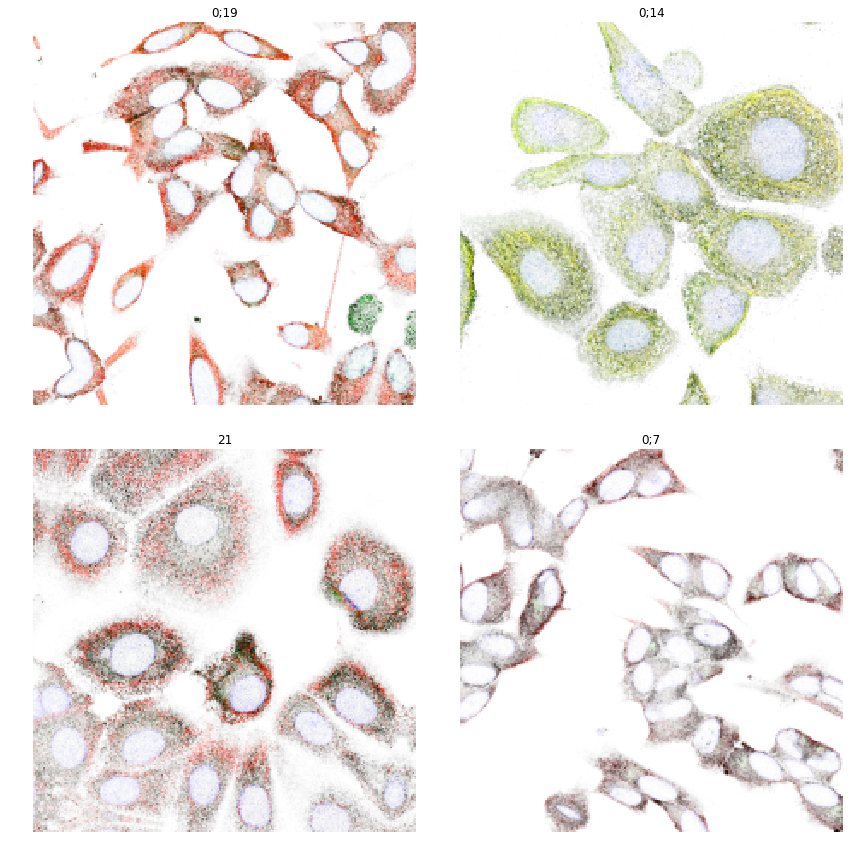

In [21]:
data.show_batch(rows=2, figsize=(12,12))

In [22]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [23]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [24]:
f1_score = partial(fbeta, thresh=0.4, beta=1)

In [25]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [26]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=FocalLoss(),  # Compare it eith F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


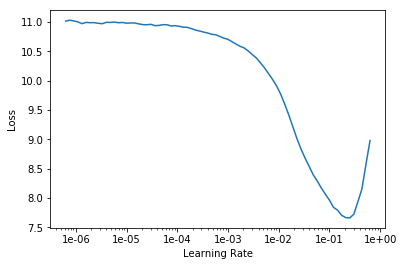

In [28]:
learn.recorder.plot()

In [29]:
lr = 3e-2

In [30]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,1.201514,1.088703,0.468632
2,1.165068,1.109758,0.508440
3,1.026420,1.234329,0.560265
4,0.891763,1.318422,0.620028
5,0.841154,1.069432,0.634381


In [31]:
learn.save('stage-1-rn50-datablocks-foculloss')

In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


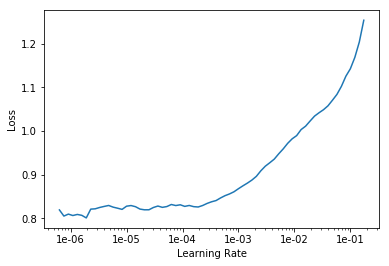

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.845392,0.977503,0.632734
2,0.872543,16.785608,0.447015
3,0.857051,1.596955,0.615369
4,0.873325,3.560940,0.605313
5,0.855148,3.416073,0.623784
6,0.811399,1.071170,0.631087
7,0.780672,0.912365,0.645285
8,0.760640,1.115584,0.670483
9,0.728494,0.821753,0.681485
10,0.704094,1.307788,0.688208


In [36]:
learn.save('stage-2-rn50-foculloss')

In [37]:
preds,_ = learn.get_preds(DatasetType.Test)

In [39]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks-foculloss.csv', header=True, index=False)

In [43]:
# Submit 
!kaggle competitions submit -c human-protein-atlas-image-classification -f /home/jupyter/tutorials/fastai/nbs/dl1/human-protein-atlas-image-classification/data/human-protein-atlas-image-classification/protein_predictions_datablocks-foculloss.csv -m "protein_predictions_datablocks-foculloss"

# This submission F1 Scores: 0.329, which is much worse then last submission with binary_cross_entropy_with_logits scoring 0.41

100%|█████████████████████████████████████████| 451k/451k [00:01<00:00, 421kB/s]
Successfully submitted to Human Protein Atlas Image Classification